In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/retinal-oct-c8/README.md
/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/val/DR/dr_val_1127.jpg
/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/val/DR/dr_val_1076.jpg
/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/val/DR/dr_val_1059.jpg
/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/val/DR/dr_val_1084.jpg
/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/val/DR/dr_val_1193.jpg
/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/val/DR/dr_val_1261.jpg
/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/val/DR/dr_val_1132.jpg
/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/val/DR/dr_val_1060.jpg
/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/val/DR/dr_val_1080.jpg
/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/val/DR/dr_val_1281.jpg
/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Da

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from itertools import cycle
import seaborn as sns


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [6]:
# Normalization values for ImageNet (same as DenseNet pretrained expects)
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
}


In [8]:
data_dir = "/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset"  # 👈 adjust if needed

image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ["train", "val", "test"]
}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2)
    for x in ["train", "val", "test"]
}

dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val", "test"]}
class_names = image_datasets["train"].classes

print("Classes:", class_names)
print("Dataset sizes:", dataset_sizes)


Classes: ['AMD', 'CNV', 'CSR', 'DME', 'DR', 'DRUSEN', 'MH', 'NORMAL']
Dataset sizes: {'train': 18400, 'val': 2800, 'test': 2800}


In [9]:
from torchvision import models

# Load pretrained DenseNet169
model = models.densenet169(pretrained=True)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:00<00:00, 162MB/s] 


In [10]:
import torch.nn as nn

num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 8)  # 8 output classes

model = model.to(device)


In [11]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [12]:
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [13]:
import copy
import time

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), "best_densenet169.pth")
                print("✅ Best model updated and saved!")

        # Save checkpoint after every epoch
        torch.save(model.state_dict(), f"checkpoint_epoch_{epoch+1}.pth")

    print(f"Training complete. Best val Acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model


In [14]:
model = train_model(model, criterion, optimizer, scheduler, num_epochs=10)


Epoch 1/10
--------------------
train Loss: 0.2398 Acc: 0.9249
val Loss: 0.0990 Acc: 0.9650
✅ Best model updated and saved!
Epoch 2/10
--------------------
train Loss: 0.1071 Acc: 0.9665
val Loss: 0.0934 Acc: 0.9682
✅ Best model updated and saved!
Epoch 3/10
--------------------
train Loss: 0.0904 Acc: 0.9708
val Loss: 0.0858 Acc: 0.9725
✅ Best model updated and saved!
Epoch 4/10
--------------------
train Loss: 0.0775 Acc: 0.9741
val Loss: 0.0905 Acc: 0.9711
Epoch 5/10
--------------------
train Loss: 0.0690 Acc: 0.9777
val Loss: 0.0826 Acc: 0.9736
✅ Best model updated and saved!
Epoch 6/10
--------------------
train Loss: 0.0425 Acc: 0.9863
val Loss: 0.0715 Acc: 0.9779
✅ Best model updated and saved!
Epoch 7/10
--------------------
train Loss: 0.0348 Acc: 0.9884
val Loss: 0.0721 Acc: 0.9782
✅ Best model updated and saved!
Epoch 8/10
--------------------
train Loss: 0.0301 Acc: 0.9898
val Loss: 0.0806 Acc: 0.9779
Epoch 9/10
--------------------
train Loss: 0.0270 Acc: 0.9910
val Loss:

In [15]:
all_labels = []
all_preds = []
all_outputs = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloaders["test"]:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_outputs.extend(outputs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_outputs = np.array(all_outputs)

print("✅ Predictions collected for evaluation")


✅ Predictions collected for evaluation


In [25]:
# Load the best model weights
model.load_state_dict(torch.load("best_densenet169.pth", map_location=device))
model = model.to(device)
model.eval()
print("Best model loaded for evaluation.")


Best model loaded for evaluation.


In [26]:
from sklearn.metrics import accuracy_score

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders["test"]:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Overall test accuracy
test_acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.9804


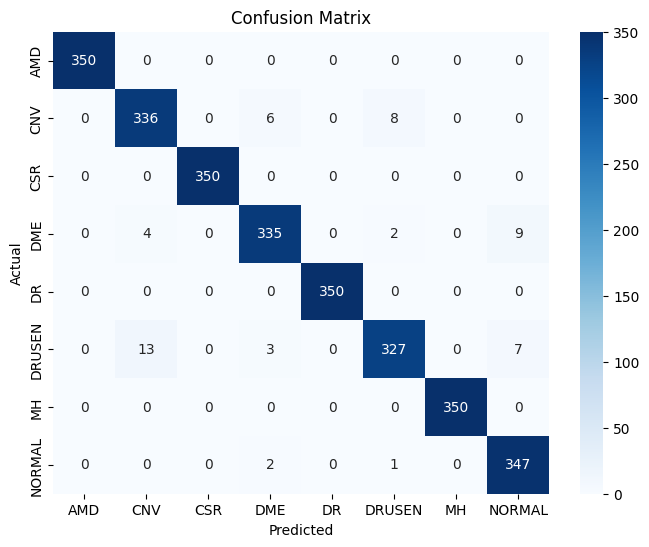

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


✅ Best DenseNet169 model loaded for evaluation.
Test Accuracy: 0.9804


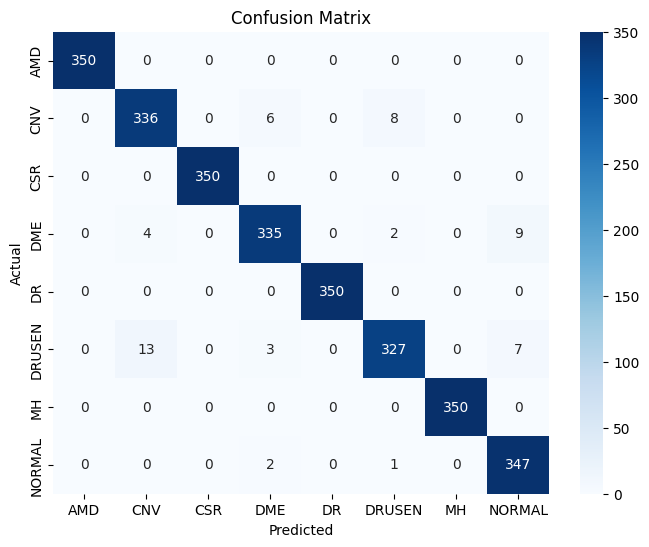

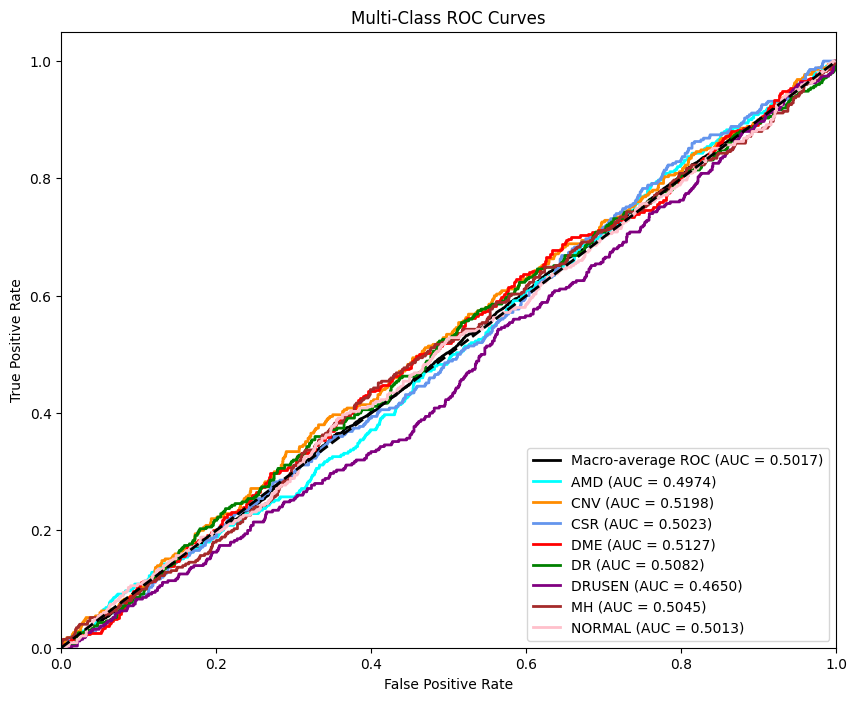

In [29]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 1️⃣ Load best model
model.load_state_dict(torch.load("best_densenet169.pth", map_location=device))
model = model.to(device)
model.eval()
print("✅ Best DenseNet169 model loaded for evaluation.")

# 2️⃣ Get test predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders["test"]:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 3️⃣ Test accuracy
test_acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {test_acc:.4f}")

# 4️⃣ Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 5️⃣ Multi-class ROC curves (macro-average)
y_test_bin = label_binarize(all_labels, classes=range(len(class_names)))

y_score = []
with torch.no_grad():
    for inputs, _ in dataloaders["test"]:
        inputs = inputs.to(device)
        outputs = model(inputs)
        y_score.append(F.softmax(outputs, dim=1).cpu().numpy())

y_score = np.vstack(y_score)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Macro-average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(class_names)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(class_names)
roc_auc["macro"] = auc(all_fpr, mean_tpr)

# Plot ROC curves
plt.figure(figsize=(10,8))
plt.plot(all_fpr, mean_tpr, color="black", lw=2, label=f"Macro-average ROC (AUC = {roc_auc['macro']:.4f})")

colors = ["aqua", "darkorange", "cornflowerblue", "red", "green", "purple", "brown", "pink"]
for i, color in zip(range(len(class_names)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"{class_names[i]} (AUC = {roc_auc[i]:.4f})")

plt.plot([0,1], [0,1], "k--", lw=2)
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curves")
plt.legend(loc="lower right")
plt.show()


✅ Best DenseNet169 model loaded for evaluation.
Test Accuracy: 0.9804


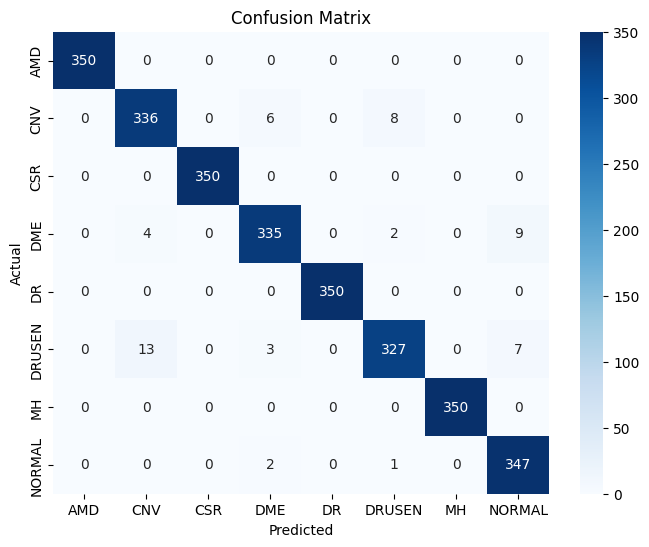

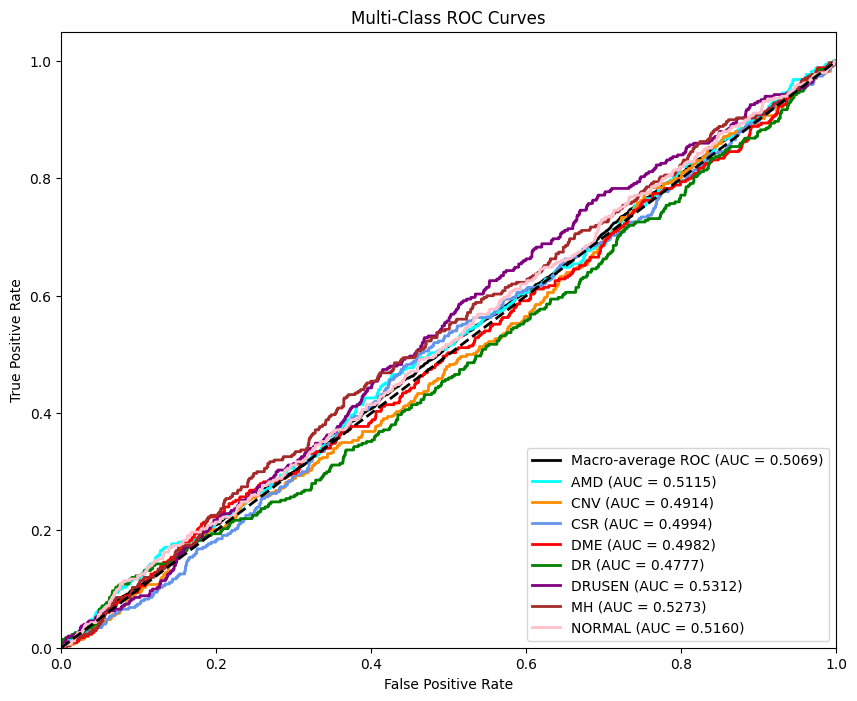

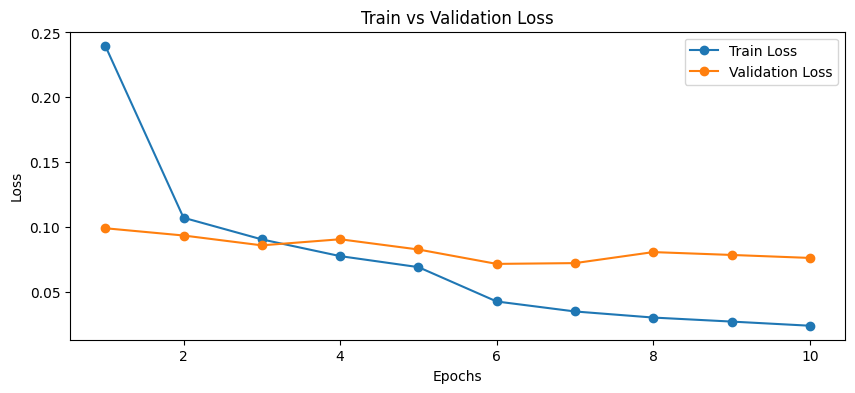

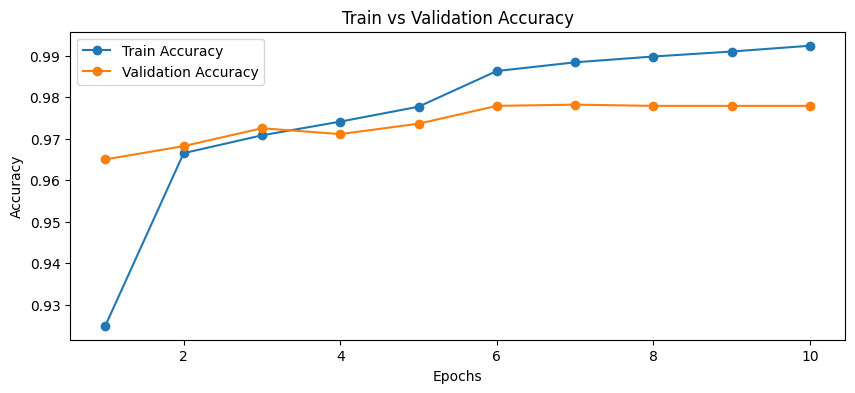

In [30]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# -------------------------
# 1️⃣ Load best model
# -------------------------
model.load_state_dict(torch.load("best_densenet169.pth", map_location=device))
model = model.to(device)
model.eval()
print("✅ Best DenseNet169 model loaded for evaluation.")

# -------------------------
# 2️⃣ Test predictions and accuracy
# -------------------------
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders["test"]:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {test_acc:.4f}")

# -------------------------
# 3️⃣ Confusion Matrix
# -------------------------
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# -------------------------
# 4️⃣ Multi-class ROC curves
# -------------------------
y_test_bin = label_binarize(all_labels, classes=range(len(class_names)))

y_score = []
with torch.no_grad():
    for inputs, _ in dataloaders["test"]:
        inputs = inputs.to(device)
        outputs = model(inputs)
        y_score.append(F.softmax(outputs, dim=1).cpu().numpy())

y_score = np.vstack(y_score)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Macro-average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(class_names)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(class_names)
roc_auc["macro"] = auc(all_fpr, mean_tpr)

# Plot ROC curves
plt.figure(figsize=(10,8))
plt.plot(all_fpr, mean_tpr, color="black", lw=2, label=f"Macro-average ROC (AUC = {roc_auc['macro']:.4f})")

colors = ["aqua", "darkorange", "cornflowerblue", "red", "green", "purple", "brown", "pink"]
for i, color in zip(range(len(class_names)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"{class_names[i]} (AUC = {roc_auc[i]:.4f})")

plt.plot([0,1], [0,1], "k--", lw=2)
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curves")
plt.legend(loc="lower right")
plt.show()

# -------------------------
# 5️⃣ Training / Validation Curves (from your log)
# -------------------------
train_losses = [0.2398, 0.1071, 0.0904, 0.0775, 0.0690, 0.0425, 0.0348, 0.0301, 0.0270, 0.0238]
val_losses   = [0.0990, 0.0934, 0.0858, 0.0905, 0.0826, 0.0715, 0.0721, 0.0806, 0.0784, 0.0761]

train_accs   = [0.9249, 0.9665, 0.9708, 0.9741, 0.9777, 0.9863, 0.9884, 0.9898, 0.9910, 0.9924]
val_accs     = [0.9650, 0.9682, 0.9725, 0.9711, 0.9736, 0.9779, 0.9782, 0.9779, 0.9779, 0.9779]

epochs = range(1, len(train_losses)+1)

# Loss plot
plt.figure(figsize=(10,4))
plt.plot(epochs, train_losses, label="Train Loss", marker='o')
plt.plot(epochs, val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.show()

# Accuracy plot
plt.figure(figsize=(10,4))
plt.plot(epochs, train_accs, label="Train Accuracy", marker='o')
plt.plot(epochs, val_accs, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.show()
